In [1]:
from glob import glob
from os.path import basename, isfile
import pandas as pd
from re import search
import numpy as np
import cv2
from cv2.aruco import extendDictionary, CORNER_REFINE_SUBPIX, DetectorParameters

In [89]:
bilder = pd.DataFrame(glob(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/**/*.jpg"), columns=["path"])
bilder["camera"] = [int(basename(path)[6:8]) for path in bilder["path"]]
bilder["focus"] = [
    float(search("(?<=\/F)\d{2}(?=\/)", i).group()) for i in bilder["path"]]
bilder["image"] = bilder.index
bilder.set_index("image", inplace=True)
bilder

,path,camera,focus
image,,,
0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,1.0
2,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,3,1.0
3,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0
4,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,5,1.0
...,...,...,...
133,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,20,10.0
134,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,10.0
135,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,22,10.0


In [90]:
cameras = pd.DataFrame(bilder["camera"].unique(), columns=["camera"])
cameras.set_index("camera", inplace=True)
cameras[["tx", "ty", "tz", "rx", "ry", "rz", "wcx", "wcy", "wcz"]] = None
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None
10,None,None,None,None,None,None,None,None,None


In [ ]:
sift = cv2.SIFT_create()  # type: ignore

for img_id, img in bilder.iterrows():
    if isfile(img["path"] + '.npz'):
        continue
    # Load the image
    image = cv2.imread(img["path"])

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect SURF keypoints and compute descriptors
    kp, des = sift.detectAndCompute(gray, None)
    pt = np.array([n.pt for n in kp])
    np.savez_compressed(img["path"] + '.npz', des=des, pt=pt)

In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


def match(image1: str, image2: str):
    data1 = np.load(image1 + '.npz')
    data2 = np.load(image2 + '.npz')
    k1, d1 = data1["pt"], data1["des"]
    k2, d2 = data2["pt"], data2["des"]

    matches = flann.knnMatch(d1, d2, k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance and np.linalg.norm(k1[m.queryIdx]-k2[m.trainIdx], ord=1) < 200:
            good.append([m.queryIdx, m.trainIdx])
    return good

In [ ]:
vk = bilder.assign(key=1).merge(bilder.assign(key=1), on='key',
                                suffixes=('1', '2')).drop('key', axis=1)
vk = vk[vk["id1"] < vk["id2"]]
vk = vk[(abs(vk["camera1"] - vk["camera2"]) < 6) |
        (abs(vk["camera1"] - vk["camera2"]) > 18)]
vk

In [ ]:
verknuepfungen: pd.DataFrame
try:
    verknuepfungen = pd.read_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/verknuepfungen.csv")

except FileNotFoundError:
    verknuepfungen_list: list = []
    for _, row in vk.iterrows():
        if row['id1'] > row['id2']:
            continue
        # print(row['id1'], row['id2'])
        matches = match(row["path1"], row["path2"])
        for m in matches:
            verknuepfungen_list.append([row["id1"], m[0], row["id2"], m[1]])

    verknuepfungen = pd.DataFrame(
        verknuepfungen_list, columns=["id1", "idx1", "id2", "idx2"])
    verknuepfungen.to_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/verknuepfungen.csv", index=False)

In [ ]:
verknuepfungen["pid"] = verknuepfungen.index
verknuepfungen

In [ ]:
for i, _ in verknuepfungen.iterrows():
    row = verknuepfungen.iloc[i]
    # if row.pid % 2000 == 0:
    #    print(i)
    verknuepfungen.loc[(verknuepfungen.pid > row.pid) & (
        verknuepfungen.id1 == row.id2) & (verknuepfungen.idx1 == row.idx2), 'pid'] = row.pid

In [ ]:
pp = pd.concat([verknuepfungen[["pid", "id1", "idx1"]].rename(columns={"id1": "id", "idx1": "idx"}),
                verknuepfungen[["pid", "id2", "idx2"]].rename(columns={"id2": "id", "idx2": "idx"})])
pp.drop_duplicates(inplace=True)

In [241]:
# pp.to_csv("/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/passpunkte.csv")
pp = pd.read_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/passpunkte.csv")

In [242]:
pp.rename(columns={"pid": "point_id", "id": "image",
          "idx": "point_idx"}, inplace=True)
pp.rename(columns={"Unnamed: 0": "id"}, inplace=True)
pp.reset_index(drop=True, inplace=True)
pp.set_index("id", inplace=True)
pp

,point_id,image,point_idx
id,,,
0,0,0,4092
1,1,0,18657
2,2,0,18728
3,3,0,18800
4,4,0,18844
...,...,...,...
111527,111527,134,319
111530,31165,134,354
111535,111535,134,388


In [248]:
joined_df = pp.merge(bilder, on='image').sort_values(["camera", "point_idx"])
xy = []
joined_df

,point_id,image,point_idx,path,camera,focus
81985,92275,69,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0
95139,71422,92,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,6.0
113730,71658,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0
113783,71249,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0
58049,71422,46,1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0
...,...,...,...,...,...,...
81965,70116,68,7866,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0
81966,70117,68,7871,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0
81968,70119,68,7882,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0
81967,70118,68,7887,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0


In [249]:
pts_ = []
for i, row in bilder.iterrows():
    l = np.load(file=row["path"] + '.npz')["pt"]
    [pts_.append([i, n, p[0], p[1]]) for n, p in enumerate(l)]
pts = pd.DataFrame(pts_, columns=["image", "idx", "x", "y"])

In [250]:
pts

,image,idx,x,y
0,0,0,2.412978,1667.347290
1,0,1,3.420322,2537.289795
2,0,2,3.420322,2537.289795
3,0,3,4.687777,2574.825195
4,0,4,5.092439,1510.068115
...,...,...,...,...
866602,137,1420,4527.503906,1032.616089
866603,137,1421,4537.976562,2236.974121
866604,137,1422,4541.773438,959.387695
866605,137,1423,4548.978027,1071.667358


In [251]:
joined_df.merge(pts, on=["image", "idx"])

In [91]:
coords = pd.read_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/marker.txt", sep=";", header=2, names=["marker", "wx", "wy", "wz"])
coords.set_index("marker", inplace=True)
coords.dropna(inplace=True)
coords

,wx,wy,wz
marker,,,
71,-0.067445,0.326679,0.028320
72,-0.093609,0.305970,0.028604
73,-0.093261,0.305538,0.062565
30,-0.211562,0.202564,0.062370
31,-0.211726,0.202705,0.028728
...,...,...,...
193,0.463443,-0.074490,0.357178
160,0.399303,0.195902,0.175359
161,0.375965,0.220108,0.175731


In [5]:
aruco_dict = extendDictionary(32, 3)
parameter = DetectorParameters()
parameter.cornerRefinementMethod = CORNER_REFINE_SUBPIX
LUT_IN = [0, 158, 216, 255]
LUT_OUT = [0, 22, 80, 176]
lut = np.interp(np.arange(0, 256),
                LUT_IN, LUT_OUT).astype(np.uint8)
detector = cv2.aruco.ArucoDetector(aruco_dict, parameter)

In [13]:
liste = []

for img_id, img in bilder.iterrows():
    imgCV = cv2.imread(img.path)
    gray = cv2.cvtColor(imgCV, cv2.COLOR_BGR2GRAY)
    tmp_corners, tmp_ids, t = detector.detectMarkers(
        gray)

    if tmp_ids is None:
        continue
    for c, i in zip(tmp_corners, tmp_ids):
        for k in range(len(c[0])):
            m: int = i[0]*10+k
            x, y = c[0][k]
            liste.append([img_id, m, x, y])


aruco = pd.DataFrame(liste, columns=["image", "marker", "x", "y"])
aruco["id"] = aruco.index
aruco.set_index("id", inplace=True)
aruco[['inlier']] = False
aruco

,image,marker,x,y,inlier
id,,,,,
0,0,130,559.947083,928.506714,False
1,0,131,618.573547,1081.224731,False
2,0,132,463.065948,1176.444458,False
3,0,133,395.642670,1023.020630,False
4,0,70,2970.246582,477.649963,False
...,...,...,...,...,...
1051,114,103,2669.963867,477.010437,False
1052,114,70,1519.000000,1248.000000,False
1053,114,71,1517.000000,1403.000000,False


In [155]:
vz_param = [2.63572488e+01,  6.31322513e-01, -9.88069511e+00,  2.92706002e+01,
            -4.15690296e-03, -1.99188205e-02, -1.01408404e-04,  2.60612862e-06,
            2.79208519e-02]
# cameras[["df", "dcx", "dcy", "dff", "v1f", "v2f",
#         "v3f", "v4f", "v5f"]] = vz_param


def calibrate(f, parameter=vz_param) -> tuple:
    x = parameter
    cameraMatrix = np.array(
        [[3385+x[0]+x[3]*f, 0, 2304+x[1]], [0, 3385+x[0]+x[3]*f, 1296+x[2]], [0, 0, 1]])
    distCoeffs = np.array([x[4:9]])*f
    return cameraMatrix, distCoeffs

In [156]:
def create_joined():
    mm = aruco.reset_index().merge(coords, on="marker").dropna().merge(
        bilder, on='image').merge(cameras, on='camera')
    mm.set_index("id", inplace=True)
    return mm


mm = create_joined()
mm

,image,marker,x,y,inlier,wx,wy,wz,path,camera,focus,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
id,,,,,,,,,,,,,,,,,,,,
0,0,130,559.947083,928.506714,False,-0.271953,-0.114972,0.062191,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
1,0,131,618.573547,1081.224731,False,-0.272443,-0.115302,0.028549,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
2,0,132,463.065948,1176.444458,False,-0.263960,-0.147964,0.028789,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
3,0,133,395.642670,1023.020630,False,-0.263656,-0.147620,0.062538,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
5,0,71,2950.927734,617.187866,True,-0.067445,0.326679,0.028320,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,108,63,1563.344849,1059.883057,False,0.465339,0.123830,0.062603,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0,-0.030931,0.060385,0.228084,1.307993,-1.237647,1.195204,-0.222076,-0.030321,0.079929
996,85,60,1721.000000,1068.000000,True,0.472215,0.090849,0.062837,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,5.0,-0.030931,0.060385,0.228084,1.307993,-1.237647,1.195204,-0.222076,-0.030321,0.079929
997,85,61,1726.070435,1216.332764,True,0.472431,0.090633,0.028969,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,5.0,-0.030931,0.060385,0.228084,1.307993,-1.237647,1.195204,-0.222076,-0.030321,0.079929


In [189]:
cameras[["tx", "ty", "tz", "rx", "ry", "rz"]] = None
aruco[['inlier']] = False

c = 3385
camMat = np.array([[c, 0, 0], [0, c, 0],
                  [0, 0, 1]], dtype=np.float64)

for i, m in mm.groupby('camera'):
    # print(m)
    if len(m) < 4:
        continue
    xy = []
    xyz = []
    for img_id, n in m.groupby('image'):
        xyz_ = n[['wx', 'wy', 'wz']].values
        xy_ = n[['x', 'y']].values
        camera_matrix, dist_coeffs = calibrate(
            n["focus"].values[0], vz_param)
        xy.append(cv2.undistortPoints(xy_, camera_matrix,
                  dist_coeffs,   P=camMat))
        xyz.append(xyz_)
    xy = np.concatenate(xy).reshape(-1, 2)
    xyz = np.concatenate(xyz).reshape(-1, 3)
    _, rvec, tvec, inliers = cv2.solvePnPRansac(
        xyz, xy, camMat, np.zeros(5), reprojectionError=10.0)
    cameras.loc[m['camera'].values[0], ["tx", "ty", "tz"]] = tvec.T[0]
    cameras.loc[m['camera'].values[0], ["rx", "ry", "rz"]] = rvec.T[0]
    indizes = m.index.to_numpy()
    for inl in inliers:
        aruco.loc[indizes[inl], 'inlier'] = True

len(aruco[aruco["inlier"]])

689

In [164]:
for key, p in cameras.iterrows():
    rt = p[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
    R = cv2.Rodrigues(rt)[0]
    R = np.linalg.inv(R)
    t = p[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T
    t = -R@t
    cameras.loc[key, ["wcx", "wcy", "wcz"]] = t
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,-0.026005,0.048325,0.570262,2.116024,0.826723,-0.384118,0.296398,-0.292708,0.393295
2,-0.046057,0.055396,0.48402,1.902076,0.731578,-0.457415,0.31006,-0.279507,0.255351
3,-0.059636,0.080425,0.404285,1.422043,0.594697,-0.611888,0.328652,-0.249516,0.056574
4,0.0174,0.104348,0.576553,1.644805,1.608859,-0.865344,0.421112,-0.023599,0.407078
5,0.016305,0.076984,0.495371,1.48925,1.471638,-0.99464,0.431374,-0.022933,0.254901
6,0.018187,0.074237,0.421115,1.191802,1.174523,-1.218387,0.42314,-0.022918,0.060054
7,0.10634,0.12696,0.628824,1.014208,2.425603,-1.090486,0.337975,0.202528,0.517303
9,0.173913,0.068391,0.398223,1.142813,1.804959,-1.347934,0.397177,0.008482,0.188899
10,0.109431,0.134149,0.503871,-0.009354,2.850293,-1.332293,0.106461,0.301336,0.426286


In [187]:
import plotly.graph_objs as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=cameras['wcx'], y=cameras['wcy'],
                z=cameras['wcz'], mode='markers', name='Original Points')])

# Add labels to the plot
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rotation and Translation Vectors in 3D')
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [166]:
daten = aruco[aruco["inlier"]].merge(bilder, on='image')
daten

,image,marker,x,y,inlier,path,camera,focus
0,0,72,2799.633789,608.245117,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
1,0,73,2812.600830,470.871674,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
2,0,30,2099.141357,454.248505,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
3,0,31,2106.843994,591.385132,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
4,0,32,1966.932495,623.684937,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
...,...,...,...,...,...,...,...,...
580,108,10,2601.000000,493.000000,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0
581,108,13,2611.835205,317.767487,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0
582,108,61,1726.000000,1220.000000,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0
583,111,150,1848.458862,824.978821,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,6.0


In [167]:
camPos = cameras[['rx', 'ry', 'rz', 'tx', 'ty', 'tz']
                 ].to_numpy(dtype=np.float64)
camPosIdx = cameras.index.to_numpy()
numCamParams = 6
numCams = len(camPosIdx)

In [168]:
pos = coords.to_numpy(dtype=np.float64)
posPosIdx = coords.index.to_numpy()
numPosParams = 3
numPos = len(posPosIdx)

In [208]:
def fun(x):
    diff = []
    x = np.array(x)
    cam_param = x[:9]
    cams = {id: values for id, values in zip(
        camPosIdx, x[9:numCamParams*numCams+9].reshape(-1, numCamParams))}
    posx = {id: values for id, values in zip(
        posPosIdx, x[numCamParams*numCams+9:].reshape(-1, numPosParams))}
    for i, row in daten.iterrows():
        cameraMatrix, distCoeffs = calibrate(
            row["focus"], cam_param)
        rvec = cams[row["camera"]][0:3]
        tvec = cams[row["camera"]][3:6]
        imgpoints, _ = cv2.projectPoints(
            np.array([posx[row["marker"]]], np.float32), rvec, tvec, cameraMatrix, distCoeffs)
        d_ = imgpoints[0][0]-row[['x', 'y']].values
        diff.append(np.linalg.norm(d_))

    for i in (pos - x[numCamParams*numCams+9:].reshape(-1, numPosParams)):
        diff.append(np.linalg.norm(i))

    return diff

In [209]:
x0 = np.hstack([vz_param, camPos.flatten(), pos.flatten()])

In [211]:
from scipy.sparse import lil_matrix
A = lil_matrix((len(daten)+len(pos), len(x0)), dtype=int)
for i, (key, row) in enumerate(daten.iterrows()):
    A[i, 0:9] = 1
    A[i, 9+np.where(camPosIdx == row["camera"])[0][0]*numCamParams +
        np.arange(numCamParams)] = 1
    A[i, 9+len(camPosIdx)*numCamParams +
        np.where(posPosIdx == row["marker"])[0][0]*numPosParams + np.arange(numPosParams)] = 1
for i in range(len(pos)):
    A[len(daten)+i, 9+len(camPosIdx)*numCamParams +
        i*numPosParams + np.arange(numPosParams)] = 1

In [212]:
np.array(fun(x0))

array([ 4.60793173,  2.39454723,  5.17682626,  5.9889529 ,  5.06122316,
        6.6534245 ,  6.69481433,  5.61706962,  3.18460719,  3.26406425,
        7.60457334,  0.18055119,  2.981007  ,  2.54929596,  3.83133796,
        6.06860142,  3.92674364,  2.28524521,  1.33047617,  3.25617935,
        7.10871394,  2.158573  ,  4.51351209,  1.51654199,  2.81398033,
        4.15827804,  3.16987044,  2.68733449,  2.29576536,  3.34226501,
        1.84231503,  2.93202865,  5.86954422,  5.42422278,  2.26456475,
        4.56065127,  4.29058199,  1.72740973,  2.84204896,  3.00505673,
        4.71060563,  5.05412465,  2.96308185,  1.93917436,  2.69075318,
        6.44781306,  4.09595066,  3.83174127,  1.64903632,  1.62747506,
        2.26105257,  3.14179355,  6.55134406,  7.33959087,  5.05137519,
        4.99529532,  4.94231309,  4.75472943,  3.51931828,  1.99624069,
        3.61180232,  0.9667374 ,  4.30720793,  2.20540034,  3.69137521,
        4.9505111 ,  3.78764254,  2.82303131,  6.54291523,  4.99

In [213]:
from scipy.optimize import least_squares

res = least_squares(fun, x0, jac_sparsity=A, verbose=2,
                    x_scale='jac', method='trf', xtol=1e-5, loss='linear')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5263e+03                                    7.92e+05    
       1              4         6.3794e+03      1.47e+02       8.40e-02       9.72e+05    
       2              5         6.3119e+03      6.75e+01       4.08e-03       5.39e+05    
       3              6         6.2758e+03      3.61e+01       3.09e-04       4.33e+05    
`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 6.5263e+03, final cost 6.2758e+03, first-order optimality 4.33e+05.


In [214]:
from scipy import linalg
jac = res.jac.todense()
cov = linalg.pinv(jac.T @ jac)
chi2dof = np.sum(res.fun**2)/(res.fun.size - res.x.size)
cov *= chi2dof
perr = np.sqrt(abs(np.diag(cov)))
perr

array([1.06953482e-01, 1.14459132e-04, 2.87440182e-01, 5.05286690e-01,
       5.75961345e-04, 1.06458297e-03, 1.95440366e-04, 8.71613156e-05,
       3.69114999e-03, 4.38070376e-03, 2.06902207e-03, 2.15417249e-03,
       6.31432880e-04, 1.90776877e-03, 2.24759996e-03, 2.76999253e-03,
       9.48531715e-04, 2.12846536e-03, 2.90525700e-04, 7.61199526e-04,
       1.33055535e-03, 1.10933003e-03, 4.50281470e-04, 1.43039772e-03,
       2.40503299e-04, 4.98816006e-04, 3.02130954e-04, 1.17056859e-03,
       1.70430013e-03, 1.34828261e-03, 4.30284473e-04, 3.91203564e-04,
       8.77628645e-04, 1.41833326e-03, 1.01531556e-03, 1.45460409e-03,
       2.21854439e-04, 4.22785576e-04, 6.68660971e-04, 1.01277033e-03,
       1.21509883e-03, 1.30250230e-03, 2.37900815e-04, 3.86049500e-04,
       9.18287954e-04, 1.79953327e-03, 4.56611428e-03, 1.06349330e-02,
       6.52081436e-04, 8.17830383e-04, 3.84419191e-03, 1.39432268e-02,
       1.14711583e-03, 1.59547691e-03, 3.41551760e-04, 9.55059620e-04,
      

In [215]:
res.x/perr

array([ 2.46376992e+02,  5.51653195e+03, -3.41110830e+01,  5.79321662e+01,
       -7.22771130e+00, -1.87035790e+01, -2.96110821e-01,  4.59123637e-02,
        7.59160890e+00,  4.83006760e+02,  3.99463917e+02, -1.78017558e+02,
       -4.10331289e+01,  2.53164107e+01,  2.53675887e+02,  6.86677284e+02,
        7.71413900e+02, -2.14840957e+02, -1.58443560e+02,  7.27675284e+01,
        3.63743953e+02,  1.28187375e+03,  1.32074955e+03, -4.27743574e+02,
       -2.48018682e+02,  1.61208628e+02,  1.33819029e+03,  1.40488729e+03,
        9.43927068e+02, -6.41776317e+02,  4.03748601e+01,  2.66671758e+02,
        6.56864137e+02,  1.04999960e+03,  1.44927728e+03, -6.83751725e+02,
        7.35342400e+01,  1.82050712e+02,  7.40805194e+02,  1.17677181e+03,
        9.66593706e+02, -9.35490423e+02,  7.64386511e+01,  1.92228645e+02,
        4.58633284e+02,  5.63573780e+02,  5.31182991e+02, -1.02523951e+02,
        1.63046538e+02,  1.55225224e+02,  1.63578230e+02,  8.19812906e+01,
        1.57351416e+03, -

In [216]:
vz_param - res.x[:9]

array([ 5.49984985e-03, -9.49481699e-05, -8.77616101e-02, -2.87314139e-03,
        4.81133992e-06, -2.44593766e-06, -3.10936454e-05, -7.00568992e-07,
       -1.19658321e-04])

In [217]:
fun(res.x)

[4.523114125728384,
 2.657773400249808,
 5.665943797598735,
 6.131069120214092,
 4.745332363264196,
 6.409887458435675,
 5.605104906538707,
 6.162147637020243,
 3.7393585155652276,
 3.2375743839931492,
 7.9488005072501835,
 0.6670542725785068,
 3.0194591258220664,
 2.7552025956573067,
 3.936324135105526,
 6.0970732763346565,
 4.266610351399777,
 2.8724002927444072,
 1.0703916607422896,
 2.9311651731277366,
 7.223762618308162,
 2.5423542289536685,
 4.604144100814283,
 1.0644522850663258,
 2.998140874128403,
 4.43440121973269,
 3.2658007565342824,
 2.634851814822767,
 2.117070131462176,
 2.8529738506555886,
 1.6661618214420773,
 3.50899936686518,
 6.228655861693023,
 5.9001080364199945,
 2.1258958618099113,
 4.308950776000375,
 3.8619135739378208,
 1.1422060368777973,
 3.051640161916753,
 3.186186943677063,
 4.870711759014586,
 5.3000421676442775,
 3.6909615465769186,
 1.6258980076231628,
 3.0258989294970715,
 6.2168293783409005,
 3.9114520483187643,
 3.589027068151513,
 1.58666635340629

In [218]:
pd.DataFrame(perr[numCamParams *
                  numCams+9:].reshape(-1, numPosParams)*1000)

,0,1,2
0,0.661929,0.314100,0.714611
1,0.938337,0.106268,0.870584
2,0.450979,11060.038486,0.976294
3,0.687950,0.869670,0.763744
4,0.610245,0.791701,0.797599
...,...,...,...
78,2264.344938,2264.345789,2264.345669
79,24231.557067,0.868546,0.755681
80,32420.280544,0.892246,0.974660
81,0.000225,2.067319,0.770550


In [219]:
vz_param = res.x[0:9]
cameras[['rx', 'ry', 'rz', 'tx', 'ty', 'tz']
        ] = res.x[9:9+numCamParams*numCams].reshape(-1, numCamParams)
coords[['wx', 'wy', 'wz']] = res.x[numCamParams *
                                   numCams+9:].reshape(-1, numPosParams)
for key, p in cameras.iterrows():
    rt = p[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
    R = cv2.Rodrigues(rt)[0]
    R = np.linalg.inv(R)
    t = p[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T
    t = -R@t
    cameras.loc[key, ["wcx", "wcy", "wcz"]] = t
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,-0.025910,0.048298,0.570162,2.115910,0.826500,-0.383481,0.296076,-0.292973,0.393185
2,-0.046032,0.055391,0.483981,1.902091,0.731711,-0.457282,0.30999,-0.279498,0.255367
3,-0.059649,0.080413,0.404309,1.422021,0.594709,-0.611843,0.328671,-0.249532,0.056559
4,0.017373,0.104323,0.576483,1.644517,1.608735,-0.865296,0.421158,-0.023662,0.406919
5,0.016314,0.076968,0.495348,1.489249,1.471474,-0.994588,0.431377,-0.023005,0.254842
6,0.018185,0.074210,0.421157,1.191800,1.174507,-1.218478,0.423185,-0.022893,0.060014
7,0.106320,0.126948,0.628826,1.014170,2.425442,-1.090335,0.338065,0.202454,0.517268
9,0.173916,0.068389,0.398245,1.143084,1.805003,-1.347866,0.397161,0.008462,0.188983
10,0.109441,0.134170,0.503869,-0.009412,2.850449,-1.332397,0.106372,0.301341,0.426312


In [220]:
daten = daten[np.array(fun(res.x)) < 30]

ValueError: Item wrong length 668 instead of 585.

In [221]:
coords

,wx,wy,wz
marker,,,
71,-0.067412,0.326608,0.028180
72,-0.093635,0.305969,0.028675
73,-0.093254,0.305513,0.062533
30,-0.211455,0.202446,0.062312
31,-0.211677,0.202596,0.028760
...,...,...,...
193,0.463443,-0.074490,0.357178
160,0.399281,0.195833,0.175388
161,0.375975,0.220136,0.175769


117
path      /mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...
camera                                                    3
focus                                                  10.0
Name: 117, dtype: object
tx    -0.059649
ty     0.080413
tz     0.404309
rx     1.422021
ry     0.594709
rz    -0.611843
wcx    0.328671
wcy   -0.249532
wcz    0.056559
Name: 3, dtype: object


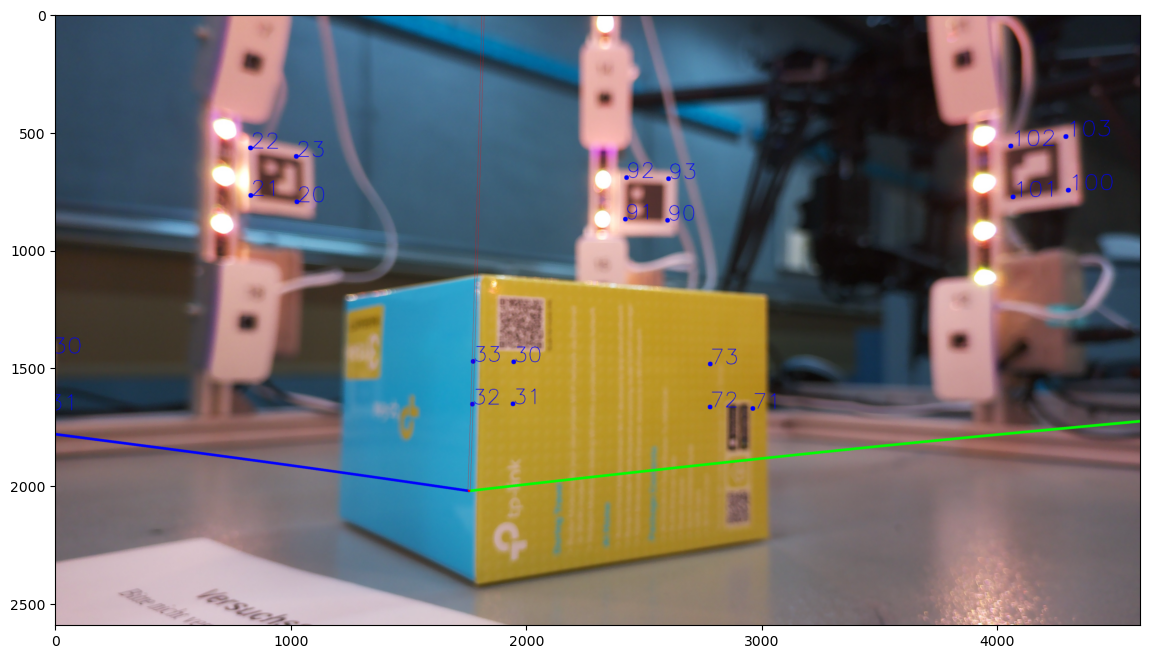

In [224]:
import matplotlib.pyplot as plt
nr = bilder.sample(1).index[0]
print(nr)
imgCV = cv2.imread(bilder.iloc[nr].path)

bild = bilder.loc[nr]
print(bild)
cam = cameras.loc[bild.camera]
print(cam)
r = cam[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
t = cam[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T

mtx, dist = calibrate(bilder.iloc[nr].focus, vz_param)
for key, p in aruco[aruco["image"] == nr].iterrows():
    cv2.circle(imgCV, (int(p["x"]), int(p["y"])), 10, (255, 0, 0), -1)
    cv2.putText(imgCV, str(
        int(key)), (int(p["x"]), int(p["y"])),  cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)
img_points, _ = cv2.projectPoints(
    coords[["wx", "wy", "wz"]].to_numpy(), r, t, mtx, dist)
for c, p in zip(coords.reset_index()['marker'].values, img_points):
    try:
        cv2.circle(imgCV, (int(p[0][0]), int(
            p[0][1])), 10, (0, 0, 255), -1)
        cv2.putText(imgCV, str(c), (int(p[0][0]), int(
            p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
    except:
        pass
"""
for i, row in coords.iterrows():
    cameraMatrix, distCoeffs = calibrate(
        row["focus"], vz_param)
    pts = row[["cx", "cy"]].values
    print(pts)
    ip, _ = cv2.projectPoints(
        np.array(pos[row["marker"]]], np.float32), r, t, cameraMatrix, distCoeffs)
    cv2.circle(imgCV, (int(row['x']), int(
        row['y'])), 10, (0, 0, 255), -1)

cam_points, _ = cv2.projectPoints(
    picWC[['x', 'y', 'z']].values, r, t, mtx, dist)
for c, p in zip(picWC.reset_index()['img'].values, cam_points):
    if nr == c:
        continue
    try:
        cv2.circle(imgCV, (int(p[0][0]), int(
            p[0][1])), 10, (0, 255, 0), -1)
        cv2.putText(imgCV, str(c+1), (int(p[0][0]), int(
            p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2)
    except:
        pass
        """
cv2.drawFrameAxes(imgCV, mtx, dist, r, t, 10, 10)
imgCV = cv2.undistort(imgCV, mtx, dist)
plt.figure(figsize=(14, 11))
plt.imshow(imgCV)
plt.show()

In [ ]:
cv2.triangulatePoints()